In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap


In [4]:
df = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f")

In [5]:
def combine_names(x):
    if 'Lawrenceville' in x:
        x = 'Lawrenceville'
    elif 'Oakland' in x:
        x = 'Oakland'
    elif 'Squirrel Hill' in x:
        x = 'Squirrel Hill'
    return x

district_names = ["Central Business District","Strip District","Shadyside","Squirrel Hill",
                  "Oakland","South Side Flats","Bloomfield","Highland Park","East Liberty",
                  "North Shore","Lawrenceville","Greenfield","Hazelwood"]

df.columns = df.columns.str.lower()
df = df.rename({'incidentneighborhood':'neighborhood'},axis='columns')
df = df[['_id','age','gender','race','neighborhood']]
df = df.dropna()
df['neighborhood'] = df['neighborhood'].apply(combine_names)
df = df[df['neighborhood'].isin(district_names)]

In [6]:
arrests = df.assign(count=1)
arrests = arrests.groupby('neighborhood',as_index=False).sum()
arrests = arrests.sort_values('count',ascending=True,ignore_index=True)
arrests = arrests[['neighborhood','count']]

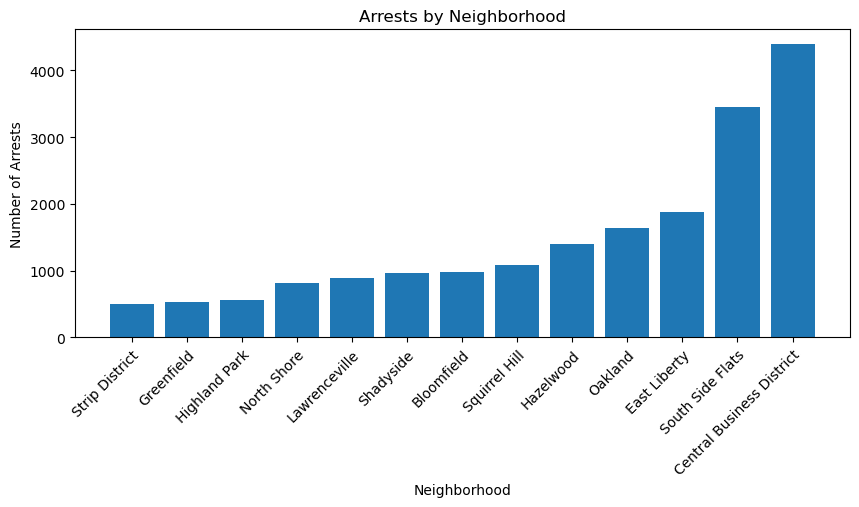

In [7]:
hoods = arrests['neighborhood']
counts = arrests['count']

fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(hoods,counts)
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Number of Arrests')
ax.set_title('Arrests by Neighborhood')
plt.savefig('Figs/arrestcounts.png',bbox_inches='tight')
plt.show()

In [8]:
lats = {
    "Central Business District":40.4418,
    "Strip District":40.4534,
    "Shadyside":40.4548,
    "Squirrel Hill":40.4456,
    "Oakland":40.4321,
    "South Side Flats":40.4284,
    "Bloomfield":40.4622,
    "Highland Park":40.4799,
    "East Liberty":40.4643,
    "North Shore":40.4467,
    "Lawrenceville":40.4698,
    "Greenfield":40.4242,
    "Hazelwood":40.409}
lons = {
    "Central Business District":-80.0004,
    "Strip District":-79.9807,
    "Shadyside":-79.9326,
    "Squirrel Hill":-79.9277,
    "Oakland":-79.9585,
    "South Side Flats":-79.9736,
    "Bloomfield":-79.9445,
    "Highland Park":-79.9165,
    "East Liberty":-79.9263,
    "North Shore":-80.0130,
    "Lawrenceville":-79.9609,
    "Greenfield":-79.9363,
    "Hazelwood":-79.941}

arrests['lat'] = arrests['neighborhood'].map(lats)
arrests['lon'] = arrests['neighborhood'].map(lons)
map_center = [40.439,-79.95]# [40.4406,-79.9959]
crime_map = folium.Map(location=map_center)
HeatMap(arrests[['lat', 'lon', 'count']].values, radius=30).add_to(crime_map)
sw = arrests[['lat', 'lon']].min().values.tolist()
ne = arrests[['lat', 'lon']].max().values.tolist()
crime_map.fit_bounds([sw, ne]) 
crime_map.save('Figs/crimemap.html')
crime_map

In [9]:
minor = df[['neighborhood','age']]
minor = minor.loc[minor['age']<18]
minor = minor.assign(count=1)
minor = minor.groupby('neighborhood',as_index=False).sum()
minor['totalcounts'] = minor['neighborhood'].map(dict(arrests[['neighborhood','count']].values))
minor['percent_minors'] = (minor['count']/minor['totalcounts'])*100
minor = minor.sort_values('percent_minors',ascending=True,ignore_index=True)
minor = minor[['neighborhood','count','totalcounts','percent_minors']]
minor

,neighborhood,count,totalcounts,percent_minors
0,Strip District,3,502,0.597610
1,North Shore,6,809,0.741656
2,South Side Flats,55,3456,1.591435
3,Oakland,34,1645,2.066869
4,Central Business District,99,4393,2.253585
5,Bloomfield,27,979,2.757916
6,Shadyside,37,961,3.850156
7,Lawrenceville,37,888,4.166667
8,Greenfield,27,535,5.046729
9,Highland Park,29,555,5.225225


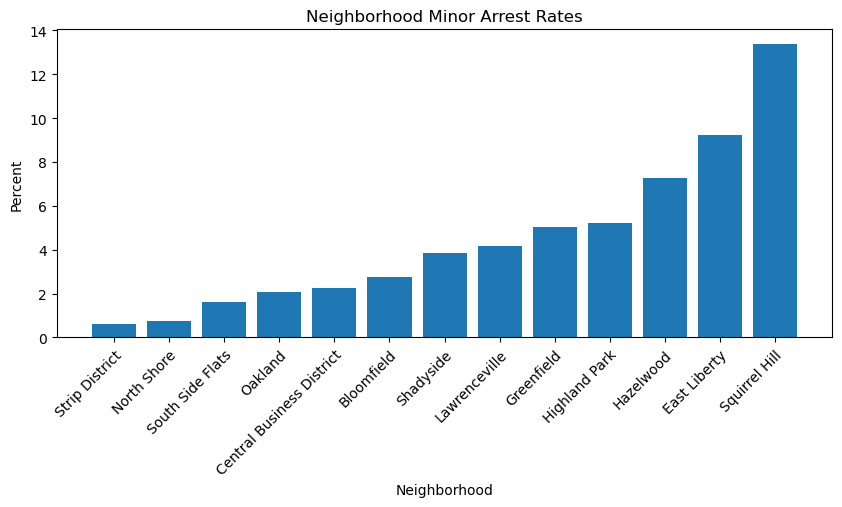

In [10]:
hoods = minor['neighborhood']
counts = minor['percent_minors']

fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(hoods,counts)
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Percent')
ax.set_title('Neighborhood Minor Arrest Rates')
plt.savefig('Figs/minorrates.png',bbox_inches='tight')
plt.show()

In [11]:
arrests['arrest_pts'] = round(max(arrests['count']/100)-(arrests['count']/100))
minor['minor_pts'] = round(max(minor['percent_minors'])-(minor['percent_minors']))
crimepts = pd.merge(arrests[['neighborhood','arrest_pts']],minor[['neighborhood','minor_pts']],on='neighborhood')
crimepts['crime_total'] = crimepts['arrest_pts'] +crimepts['minor_pts']
crimepts = crimepts.sort_values('crime_total',ascending=False,ignore_index=True)
crimepts

,neighborhood,arrest_pts,minor_pts,crime_total
0,Strip District,39.0,13.0,52.0
1,North Shore,36.0,13.0,49.0
2,Greenfield,39.0,8.0,47.0
3,Highland Park,38.0,8.0,46.0
4,Bloomfield,34.0,11.0,45.0
5,Lawrenceville,35.0,9.0,44.0
6,Shadyside,34.0,10.0,44.0
7,Oakland,27.0,11.0,38.0
8,Hazelwood,30.0,6.0,36.0
9,Squirrel Hill,33.0,0.0,33.0


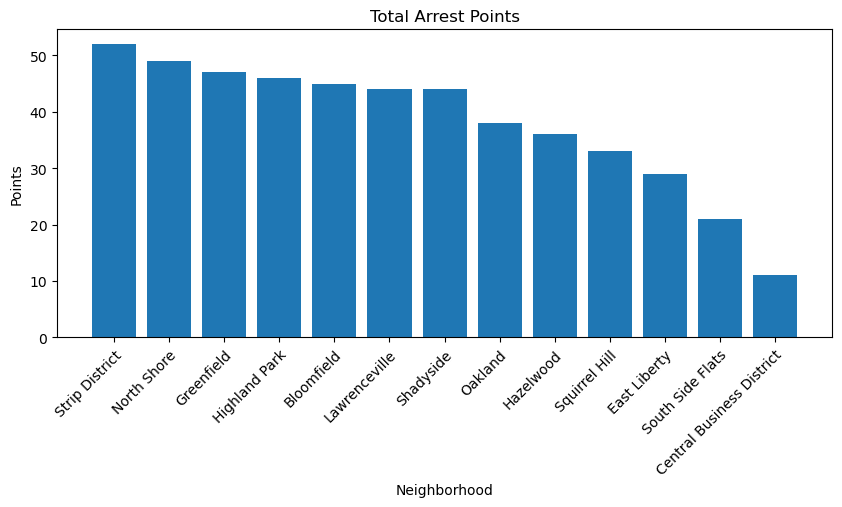

In [12]:
hoods = crimepts['neighborhood']
counts = crimepts['crime_total']

fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(hoods,counts)
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Points')
ax.set_title('Total Arrest Points')
plt.savefig('Figs/crimepts.png',bbox_inches='tight')
plt.show()

In [14]:
%store crimepts

Stored 'crimepts' (DataFrame)
